In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [17]:
data = pd.read_csv("/kaggle/input/health/survey lung cancer.csv")

In [18]:
data['LUNG_CANCER'] = data['LUNG_CANCER'].map({'YES': 1, 'NO': 0})
data['GENDER'] = data['GENDER'].map({'M':1, 'F':0})

In [19]:
print(data.head())

print(data.info())

print(data.isnull().sum())

   GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0       1   69        1               2        2              1   
1       1   74        2               1        1              1   
2       0   59        1               1        1              2   
3       1   63        2               2        2              1   
4       0   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                1         2         1         2                  2         2   
1                2         2         2         1                  1         1   
2                1         2         1         2                  1         2   
3                1         1         1         1                  2         1   
4                1         1         1         2                  1         2   

   SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN  LUNG_CANCER  
0                    2               

           GENDER         AGE     SMOKING  YELLOW_FINGERS     ANXIETY  \
count  309.000000  309.000000  309.000000      309.000000  309.000000   
mean     0.524272   62.673139    1.563107        1.569579    1.498382   
std      0.500221    8.210301    0.496806        0.495938    0.500808   
min      0.000000   21.000000    1.000000        1.000000    1.000000   
25%      0.000000   57.000000    1.000000        1.000000    1.000000   
50%      1.000000   62.000000    2.000000        2.000000    1.000000   
75%      1.000000   69.000000    2.000000        2.000000    2.000000   
max      1.000000   87.000000    2.000000        2.000000    2.000000   

       PEER_PRESSURE  CHRONIC DISEASE    FATIGUE     ALLERGY     WHEEZING  \
count     309.000000       309.000000  309.000000  309.000000  309.000000   
mean        1.501618         1.504854    1.673139    1.556634    1.556634   
std         0.500808         0.500787    0.469827    0.497588    0.497588   
min         1.000000         1.000

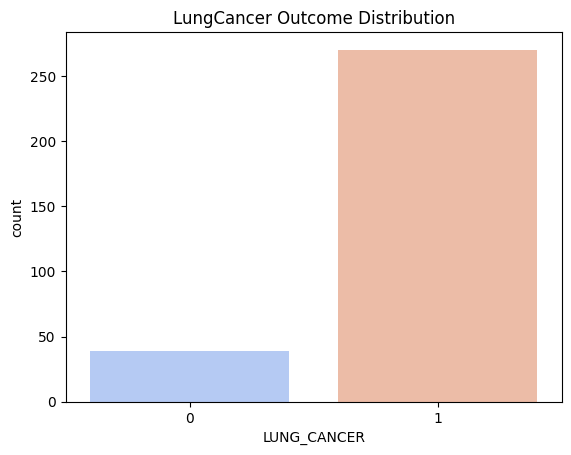

In [21]:
print(data.describe())

sns.countplot(x=data['LUNG_CANCER'], palette='coolwarm')
plt.title("LungCancer Outcome Distribution")
plt.show()

In [22]:
X = data.drop(columns=["LUNG_CANCER"])
y = data["LUNG_CANCER"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (247, 15)
Testing Data Shape: (62, 15)


In [24]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'subsample': [0.6, 0.8, 1.0], 
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'n_estimators': [100, 200, 300] 
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_xgb = xgb.XGBClassifier(**grid_search.best_params_, use_label_encoder=False, eval_metric="logloss")
best_xgb.fit(X_train, y_train)

y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

print("XGBoost Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("XGBoost Testing  Accuracy:", accuracy_score(y_test, y_pred_test))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_test))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'n_estimators': 100, 'subsample': 0.6}
XGBoost Training Accuracy: 0.9676113360323887
XGBoost Testing  Accuracy: 0.967741935483871
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.98      0.98      0.98        60

    accuracy                           0.97        62
   macro avg       0.74      0.74      0.74        62
weighted avg       0.97      0.97      0.97        62



In [25]:
param_grid2 = {
    'max_depth': [3, 5, 7],  
    'min_child_weight': [1, 3, 5],  
    'gamma': [0, 0.1, 0.3, 0.5], 
}

grid_search2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        colsample_bytree=1.0,
        learning_rate=0.01,
        n_estimators=200,
        subsample=0.6,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    param_grid=param_grid2,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search2.fit(X_train, y_train)

print("Best Parameters after second tuning:", grid_search2.best_params_)

best_xgb2 = xgb.XGBClassifier(**grid_search2.best_params_, 
                              colsample_bytree=1.0, 
                              learning_rate=0.01, 
                              n_estimators=200, 
                              subsample=0.6, 
                              use_label_encoder=False, 
                              eval_metric="logloss")

best_xgb2.fit(X_train, y_train)

y_pred_train2 = best_xgb2.predict(X_train)
y_pred_test2 = best_xgb2.predict(X_test)

print("XGBoost Training Accuracy (After Second Tuning):", accuracy_score(y_train, y_pred_train2))
print("XGBoost Testing Accuracy (After Second Tuning):", accuracy_score(y_test, y_pred_test2))
print("XGBoost Classification Report (After Second Tuning):\n", classification_report(y_test, y_pred_test2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters after second tuning: {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1}
XGBoost Training Accuracy (After Second Tuning): 0.902834008097166
XGBoost Testing Accuracy (After Second Tuning): 0.967741935483871
XGBoost Classification Report (After Second Tuning):
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.98      0.98      0.98        60

    accuracy                           0.97        62
   macro avg       0.74      0.74      0.74        62
weighted avg       0.97      0.97      0.97        62



In [26]:
import pickle
import joblib
import xgboost as xgb

with open("xgboost_diabetes_model.pkl", "wb") as file:
    pickle.dump(best_xgb2, file)

joblib.dump(best_xgb2, "xgboost_diabetes_model.joblib")

print("✅ Model saved successfully!")

✅ Model saved successfully!
